**Calibration of the age-stratified deterministic model**

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [57]:
import random
import os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
from datetime import datetime, timedelta
import scipy
from scipy.integrate import odeint
from scipy.stats import norm
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json
import corner

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
from covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2
from covid19model.models.utils import draw_sample_COVID19_SEIRD


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# import dask

# from dask.distributed import Client, progress
# client = Client(threads_per_worker=16, n_workers=1)
# client

# Get public data

In [ ]:
#df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)


In [12]:
raw_hosp_data = pd.read_csv('../data/raw/sciensano/COVID19BE_HOSP.csv', parse_dates=['DATE'])
Luik_hosp_data = raw_hosp_data[raw_hosp_data.PROVINCE=='Liège']

In [13]:
#Luik_hosp_data.plot('DATE','NEW_IN')

In [14]:
Luik_ts = Luik_hosp_data[['DATE','NEW_IN']].set_index('DATE')

<IPython.core.display.Javascript object>


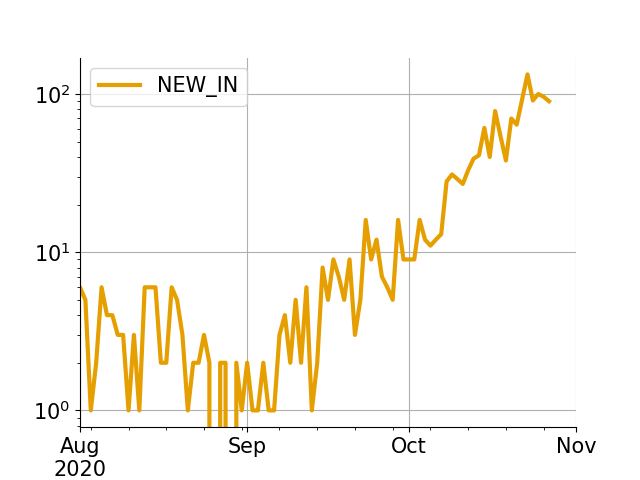

(18475, 18567)

In [15]:
fig,ax = plt.subplots()
Luik_ts.reset_index() .plot('DATE','NEW_IN', logy=True, ax=ax)
ax.set_xlim('2020-08-01', '2020-11-01')

# Load data

In [16]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
# Define the number of age categories
levels = initN.size
#province_names = pd.read_csv('../data/raw/GIS/NIS_province.csv')
initN_province = pd.read_csv('../data/interim/demographic/initN_province.csv')
initN = np.array(list(initN_province.set_index('NIS').loc[60000].iloc[:9]))

In [17]:
fig_path = '../results/calibrations_provinces/'
samples_path = '../data/interim/model_parameters/provinces/'

# Initialize the model

In [ ]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': 500,
              'l': 1,
              'tau': 5,
              'prevention': 0.5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

In [ ]:
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_wave1_1000steps'

# Calibration on first wave

In [ ]:
## First wave
start_date = '2020-03-15'
end_beta = '2020-03-25'#'2020-03-22'
end_ramp = '2020-05-23'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
len(Luik_ts.loc[end_beta:end_ramp])

In [ ]:
# function parameters 
# maxiter=100
# popsize=200
# steps_mcmc=10000


In [ ]:
samples_dict = full_calibration_wave1(model, timeseries, spatial_unit, start_date, end_beta, end_ramp, 
                                fig_path=fig_path, samples_path=samples_path,
                                initN=initN, Nc_total=Nc_total,
                                maxiter=50, popsize=50, steps_mcmc=1000)



In [ ]:
states = [['H_in']]
end_date = '2020-07-01'
data=[timeseries[start_date:end_ramp].values]

fig,ax=plt.subplots()
for i in range(10):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['policy_time'] = samples_dict['lag_time']
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(time=end_date, excess_time=samples_dict['lag_time'], start_date=start_date)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-03-10', '2020-07-01')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

# Run simulation until first september

In [3]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_wave1_1000steps_2020-10-28.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
states = [['H_in']]
start_date = samples_dict_wave1['start_date']
end_ramp = samples_dict_wave1['end_ramp']
end_date = '2020-09-01'

data=[timeseries[start_date:end_ramp].values]

fig,ax=plt.subplots()
for i in range(10):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave1['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict_wave1['l'])))
    model.parameters['tau'] = samples_dict_wave1['tau'][idx]
    model.parameters['policy_time'] = samples_dict_wave1['lag_time']
    model.parameters['prevention'] = samples_dict_wave1['prevention'][idx]
    y_model = model.sim(time=end_date, excess_time=samples_dict_wave1['lag_time'], start_date=start_date)
    ax = plot_fit(y_model,data,start_date,samples_dict_wave1['lag_time'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-03-10', end_date)
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
# out_sept = model.sim(time='2020-09-01', excess_time=samples_dict_wave1['lag_time'],start_date='2020-03-15',
#                    N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
# states = out_sept.isel(time=-1).mean(dim="draws")
# initial_states_sept = {key:states[key].values for key in initial_states.keys()}

In [ ]:
out_aug = model.sim(time='2020-08-01', excess_time=samples_dict_wave1['lag_time'],start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_aug.isel(time=-1).mean(dim="draws")
initial_states_aug = {key:states[key].values for key in initial_states.keys()}

In [ ]:
#np.sum(initial_states_sept['S'])/np.sum(initial_states['S'])*100

# Klad

<IPython.core.display.Javascript object>


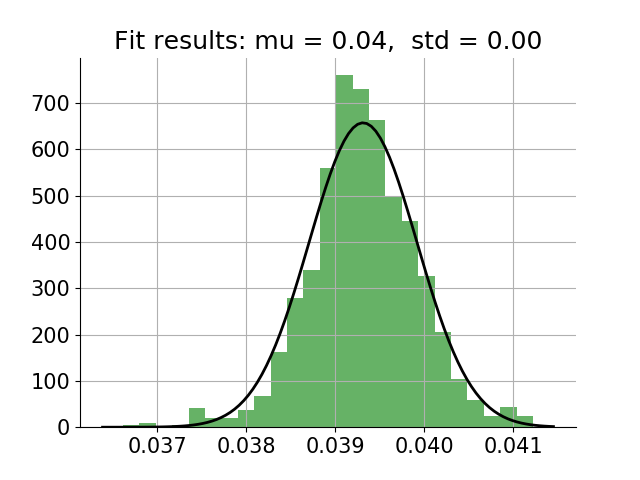

Text(0.5, 1.0, 'Fit results: mu = 0.04,  std = 0.00')

In [29]:
## Fit normal to beta-distribution
mu, std = norm.fit(samples_dict_wave1['beta'])

# Plot the histogram.
plt.hist(samples_dict_wave1['beta'], bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

In [31]:
def log_prior_normal(thetas, norm_params):
    """
    A function to compute the log of a multivariate normal prior density from a given parameter vector.
    The parameters are assumed to be independent (i.e. the MVN is a product of marginal normal distributions)
    
    Parameters
    -----------
    thetas: array
        parameter vector  
    norm_params: tuple
        contains tuples with mean and standard deviation for each theta in the parameter vector
    Returns
    -----------
    lp : float
        log of normal prior density
    Example use
    -----------
    thetas = [1.2,2]
    norm_params = ((1,0.5),(1,2))
    lp = log_prior_normal(thetas,norm_params)
    """
    thetas = np.array(thetas)
    norm_params = np.array(norm_params).reshape(len(thetas),2)
    lp = norm.logpdf(thetas, loc = norm_params[:,0], scale = norm_params[:,1])
    return np.sum(lp)

In [34]:
thetas = [1.2,2]
norm_params = ((mu,std),(mu,std))

In [35]:
log_prior_normal(thetas, norm_params)

-7043654.546410359

In [ ]:
    
thetas = [1.2,2]
norm_params = ((1,0.5),(1,2))
lp = log_prior_normal(thetas,norm_params)

# Calibration on second wave

In [18]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_wave1_1000steps_2020-10-28.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [19]:
initial_states_aug = np.load('../data/interim/prediction_provinces/Luik_initial_states_aug.npy', allow_pickle=True).item()

In [20]:
# Second wave
start_date = '2020-08-01'
end_beta = '2020-10-25'

In [21]:
len(Luik_ts.loc[start_date:end_beta])

86

In [22]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_aug = models.COVID19_SEIRD(initial_states_aug, params)

In [23]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_wave2_from_aug_1000steps'
# maxiter=100
# popsize=200
# steps_mcmc=10000


In [46]:
mu_beta, std_beta = norm.fit(samples_dict_wave1['beta'])
mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['beta'])

In [55]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])
beta_norm_params = (mu_beta, std_beta)
sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [58]:
samples_dict = full_calibration_wave2(model_aug, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, beta_norm_params,sigma_data_norm_params,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,
                                      maxiter=100, popsize=100, steps_mcmc=1000)

  1%|          | 6/1000 [00:09<25:53,  1.56s/it]Traceback (most recent call last):
  File "/Applications/miniconda3/envs/work/lib/python3.8/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/jennavergeynst/OneDrive - UGent/Corona_Postdoc/COVID19-Model/src/covid19model/optimization/objective_fcns.py", line 301, in log_probability_normal
    return lp - MLE(thetas,BaseModel,data,states,parNames,samples=samples) # must be negative for emcee
  File "/Users/jennavergeynst/OneDrive - UGent/Corona_Postdoc/COVID19-Model/src/covid19model/optimization/objective_fcns.py", line 137, in MLE
    out=BaseModel.sim(T)
  File "/Users/jennavergeynst/OneDrive - UGent/Corona_Postdoc/COVID19-Model/src/covid19model/models/base.py", line 381, in sim
    out = self._sim_single(time, start_date, excess_time)
  File "/Users/jennavergeynst/OneDrive - UGent/Corona_Postdoc/COVID19-Model/src/covid19model/models/base.py", line 298, in _sim_single
  

emcee: Exception while calling your likelihood function:
  params: [-4.48776944  9.3209006 ]
  args: (<covid19model.models.models.COVID19_SEIRD object at 0x11af32280>, ((0.03931245235710499, 0.0006070600327817083), (0.03931245235710499, 0.0006070600327817083)), [DATE
2020-08-01      6
2020-08-02      5
2020-08-03      1
2020-08-04      2
2020-08-05      6
             ... 
2020-10-21     64
2020-10-22     92
2020-10-23    133
2020-10-24     91
2020-10-25    100
Name: NEW_IN, Length: 86, dtype: int64], [['H_in']], ['sigma_data', 'beta'])
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_wave2_from_aug_1000steps_2020-10-29.json', 'r') as fp:
    samples_dict = json.load(fp)


In [ ]:
states = [['H_in']]
end_date = '2021-01-01' #end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(200):
    idx,model_aug.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model_aug.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-08-01', '2021-01-01')
ax.set_ylabel('daily hospitalizations')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

In [ ]:
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

# Run in parallel

In [ ]:
arr_list = list(nonpublic_ts.NIS.unique())

In [ ]:
def run_me_parallel(arr):
    arrond_ts = nonpublic_ts.pivot(index='DATE', columns='NIS', values='hospitalised_IN')[arr]
    samples_dict = full_calibration(model, arrond_ts, arr, start_date, end_beta, end_ramp, 
                                fig_path, samples_path)
                                #maxiter=10, popsize=10, steps_mcmc=250)
    
    states = [['H_in']]
    end_date = '2020-09-20'
    data=[arrond_ts[start_date:end_ramp].values]
    fig,ax=plt.subplots()
    for i in range(200):
        idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
        idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
        model.parameters['tau'] = samples_dict['tau'][idx]
        prevention = samples_dict['prevention'][idx]
        # Create a dictionary of past policies
        chk = {'time':   [start_date], 
              'Nc':      [prevention*(Nc_home + 0.4*Nc_work + 0.3*Nc_transport + 0.7*Nc_others + 0.2*Nc_leisure)]
              }
        y_model = model.sim(time=end_date, excess_time=samples_dict['lag_time'],checkpoints=chk)
        ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

    data_after_calib = arrond_ts[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
    plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
    legend_text=['daily \nhospitalizations']
    ax.set_xlim('2020-03-10', '2020-08-03')
    fig.savefig('../results/calibrations_arrondissements/'+str(arr)+'_'+str(datetime.date.today())+'.pdf',
                bbox_inches='tight', dpi=600)
    return

In [ ]:
tasks = []
for arr in arr_list:
    task = dask.delayed(run_me_parallel)(arr)
    tasks.append(task)
    

In [ ]:
dask.compute(*tasks, scheduler='processes')

In [ ]:
run_date = '2020-08-22'

In [ ]:
with open(samples_path+'44000'+'_'+run_date+'.json', 'r') as fp:
    samples_dict = json.load(fp)